# STAT207 Mini-Project #2 - Predicting Base Salary for Colleges


Ben Estacio

In [98]:
#Imports here
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
sns.set()

## 1. Introduction

### Intro
For people entering the workforce, it's no secret that the college one goes to can potentially unlock many ludicrous career opportunities. Obviously, more prestigious colleges will lead to higher starting salaries for recent graduates, but what other factors play into how much alumni make after college, and which are the most important? To answer these questions, I'll take a look at a dataset of the top American colleges and attempt to create a model to predict median base salary.
### Research Goal Statement
In this miniproject, my goal is to build a predictive model that will effectively predict median base salary for new datasets. To do this, I've chosen seven explanatory variables to consider using in the model; five numerical (school rank, student population, year founded, student/faculty ratio, and total grant aid) and two categorical (campus setting and college type). Additionally, I would like to ideally be able to interpret the results of the model and draw conclusions about the relationships between explanatory variables and median base salary.
### Research Motivation
A predictive model to predict median base salary for different colleges would be very helpful for predicting the median base salary for new colleges not in this dataset. Additionally, since this is a semi-recent dataset (2022), this model could possibly be used to predict median base salary for these same colleges in the present and future. This model would be immensely useful for prospective college students looking to find the best colleges to apply to in order to set themselves up for career success.

## 2. Dataset Discussion

The dataset I chose was the Top American Colleges 2022 dataset by Kabhish Mahesh on Kaggle (https://www.kaggle.com/datasets/kabhishm/top-american-colleges-2022?resource=download), downloaded on 4/3/2025.

In [99]:
df_colleges = pd.read_csv("top_colleges_2022.csv")
df_colleges.head()

,description,rank,organizationName,state,studentPopulation,campusSetting,medianBaseSalary,longitude,latitude,website,...,yearFounded,stateCode,collegeType,carnegieClassification,studentFacultyRatio,totalStudentPop,undergradPop,totalGrantAid,percentOfStudentsFinAid,percentOfStudentsGrant
0,"A leading global research university, MIT attr...",1,Massachusetts Institute of Technology,MA,12195,Urban,173700.0,-71.093539,42.359006,http://web.mit.edu,...,1861.0,MA,Private not-for-profit,Doctoral Universities: Very High Research Acti...,3,12195,4582,35299332.0,75.0,60.0
1,Stanford University sits just outside of Palo ...,2,Stanford University,CA,20961,Suburban,173500.0,-122.168924,37.431370,http://www.stanford.edu,...,1891.0,CA,Private not-for-profit,Doctoral Universities: Very High Research Acti...,4,20961,8464,51328461.0,70.0,55.0
2,One of the top public universities in the coun...,2,"University of California, Berkeley",CA,45878,Urban,154500.0,-122.258393,37.869236,http://www.berkeley.edu,...,1868.0,CA,Public,Doctoral Universities: Very High Research Acti...,19,45878,33208,64495611.0,63.0,53.0
3,Princeton is a leading private research univer...,4,Princeton University,NJ,8532,Urban,167600.0,-74.659119,40.349855,http://www.princeton.edu,...,1746.0,NJ,Private not-for-profit,Doctoral Universities: Very High Research Acti...,4,8532,5516,44871096.0,62.0,61.0
4,"Located in upper Manhattan, Columbia Universit...",5,Columbia University,NY,33882,Urban,148800.0,-73.961288,40.806515,http://www.columbia.edu,...,1754.0,NY,Private not-for-profit,Doctoral Universities: Very High Research Acti...,6,33882,8689,44615007.0,58.0,54.0


In [100]:
df_colleges.shape[0]

498

This dataset contains data on 498 colleges across the US.

## 3. Dataset Cleaning

First, I will drop the columns that I won't be using from the dataframe.

In [101]:
df_colleges = df_colleges[["medianBaseSalary", "rank", "studentPopulation", "yearFounded", "studentFacultyRatio", "totalGrantAid", "campusSetting", "collegeType"]]
df_colleges.head()

,medianBaseSalary,rank,studentPopulation,yearFounded,studentFacultyRatio,totalGrantAid,campusSetting,collegeType
0,173700.0,1,12195,1861.0,3,35299332.0,Urban,Private not-for-profit
1,173500.0,2,20961,1891.0,4,51328461.0,Suburban,Private not-for-profit
2,154500.0,2,45878,1868.0,19,64495611.0,Urban,Public
3,167600.0,4,8532,1746.0,4,44871096.0,Urban,Private not-for-profit
4,148800.0,5,33882,1754.0,6,44615007.0,Urban,Private not-for-profit


Checking for and removing implicit and explicit missing values:

In [102]:
df_colleges.isna().sum()

medianBaseSalary        7
rank                    0
studentPopulation       0
yearFounded            47
studentFacultyRatio     0
totalGrantAid           3
campusSetting           0
collegeType             0
dtype: int64

In [103]:
df_colleges.dtypes

medianBaseSalary       float64
rank                     int64
studentPopulation        int64
yearFounded            float64
studentFacultyRatio      int64
totalGrantAid          float64
campusSetting           object
collegeType             object
dtype: object

In [104]:
original_length = len(df_colleges)
df_colleges = df_colleges.dropna()
original_length - len(df_colleges)

49

49 colleges were dropped after initial data cleaning. These were removed because we can't work with NaN values when creating our model, so they have to be dropped.

A quick look at the pairplot to help identify outliers in the dataset:

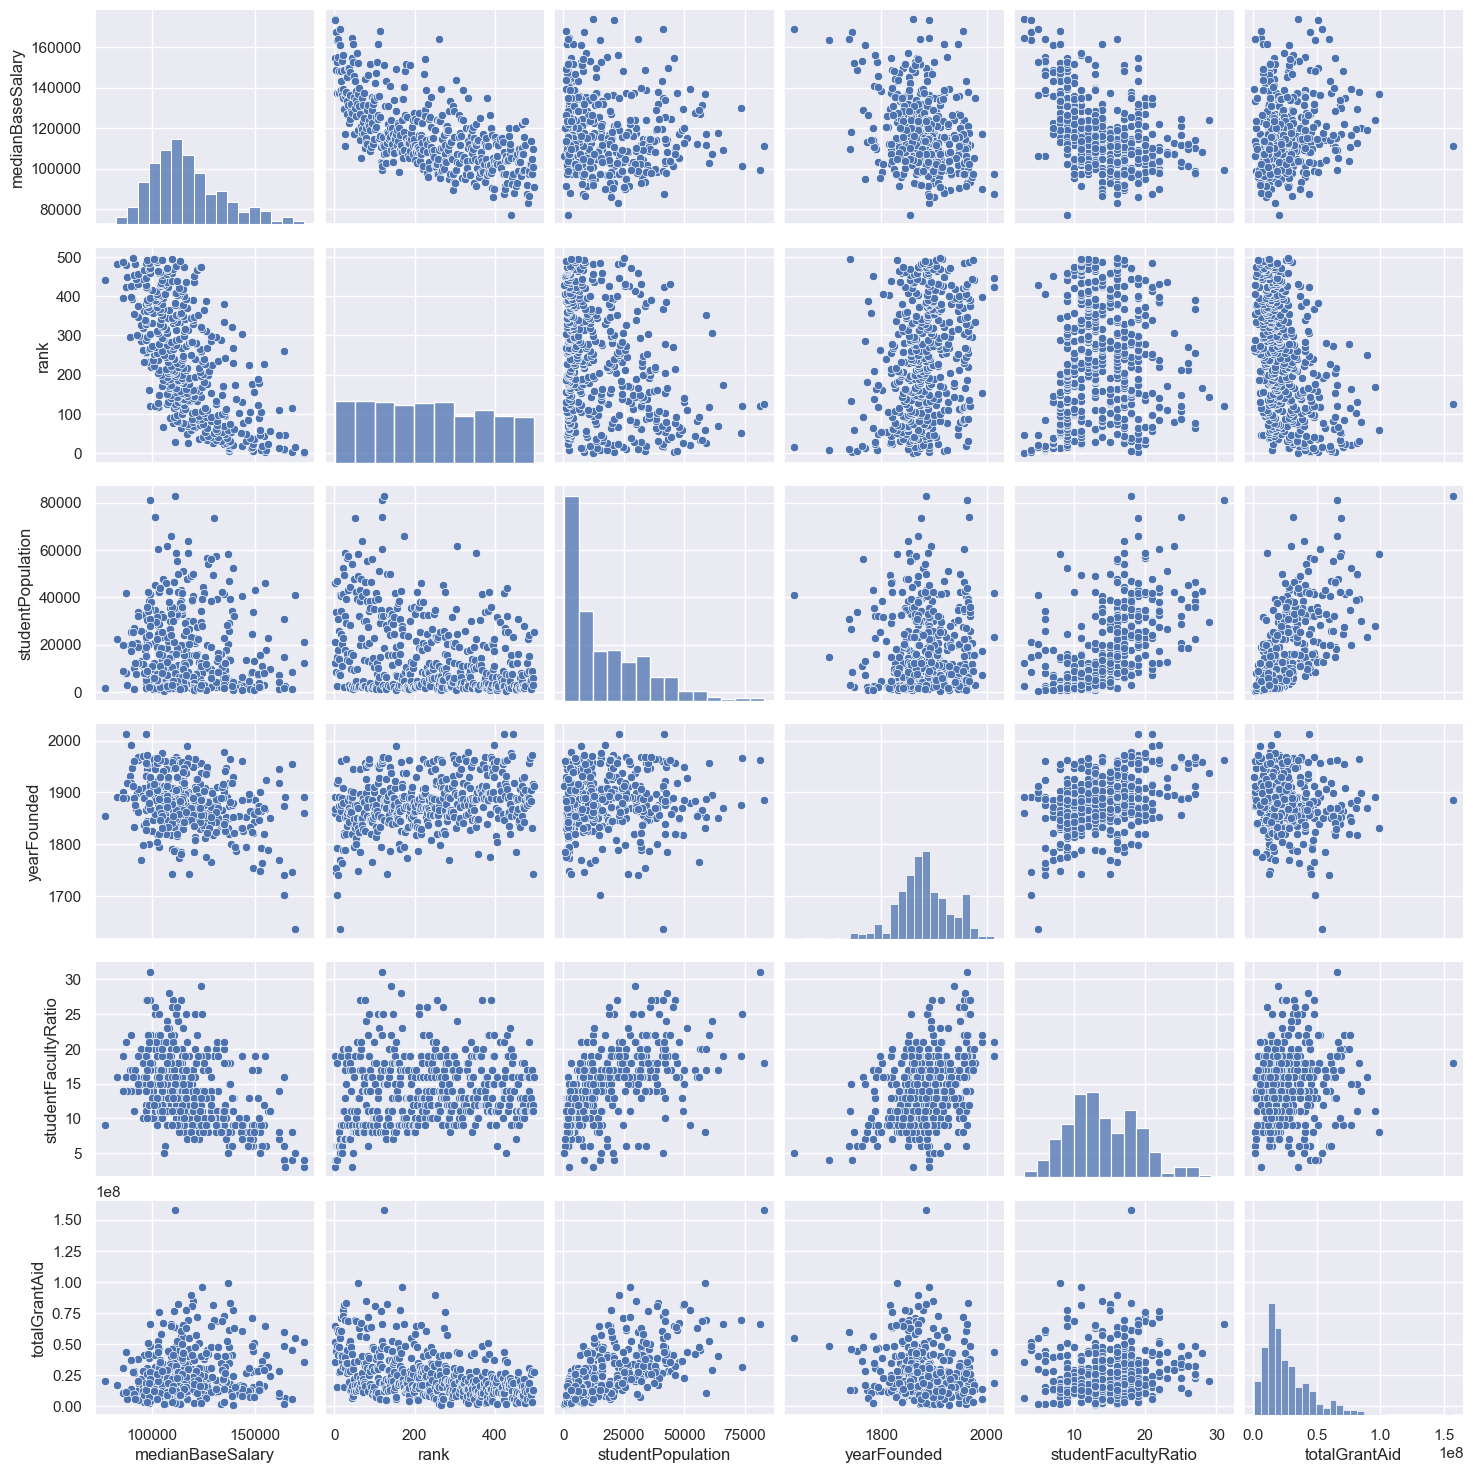

In [105]:
sns.pairplot(df_colleges)

There are a few apparent outliers in the data. I will remove them to make the models more accurate for non-outlier points at the expense of the model not being as representative of the full dataset.

In [106]:
df_colleges = df_colleges[(df_colleges["totalGrantAid"] < 125000000) & (df_colleges["yearFounded"] > 1700)]
len(df_colleges)

447

447 schools remain in our dataset, so there were 51 colleges dropped overall.

## 4. Preliminary Analysis

First, I will fit a preliminary full model including all of the data, then check the fitted values vs residuals plot to see if the linearity assumption is met:

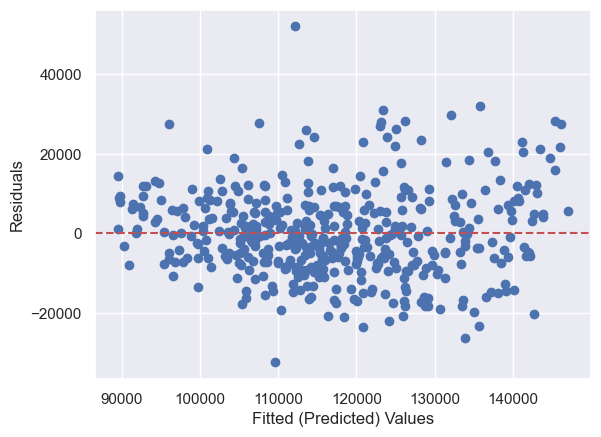

In [107]:
initial_model = smf.ols(formula="medianBaseSalary~rank+studentPopulation+yearFounded+studentFacultyRatio+totalGrantAid+campusSetting+collegeType", data=df_colleges).fit()
plt.scatter(initial_model.fittedvalues, initial_model.resid)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Fitted (Predicted) Values")
plt.ylabel("Residuals")
plt.show()

For the most part, this model fits the linearity assumption decently well. However, there are some places on the plot where there is an uneven distribution of positive and negative residuals (such as when fitted values are greater than 140000). To attempt to get a clearer picture of why, let's revisit the pairplot of the relationships between the numerical variables:

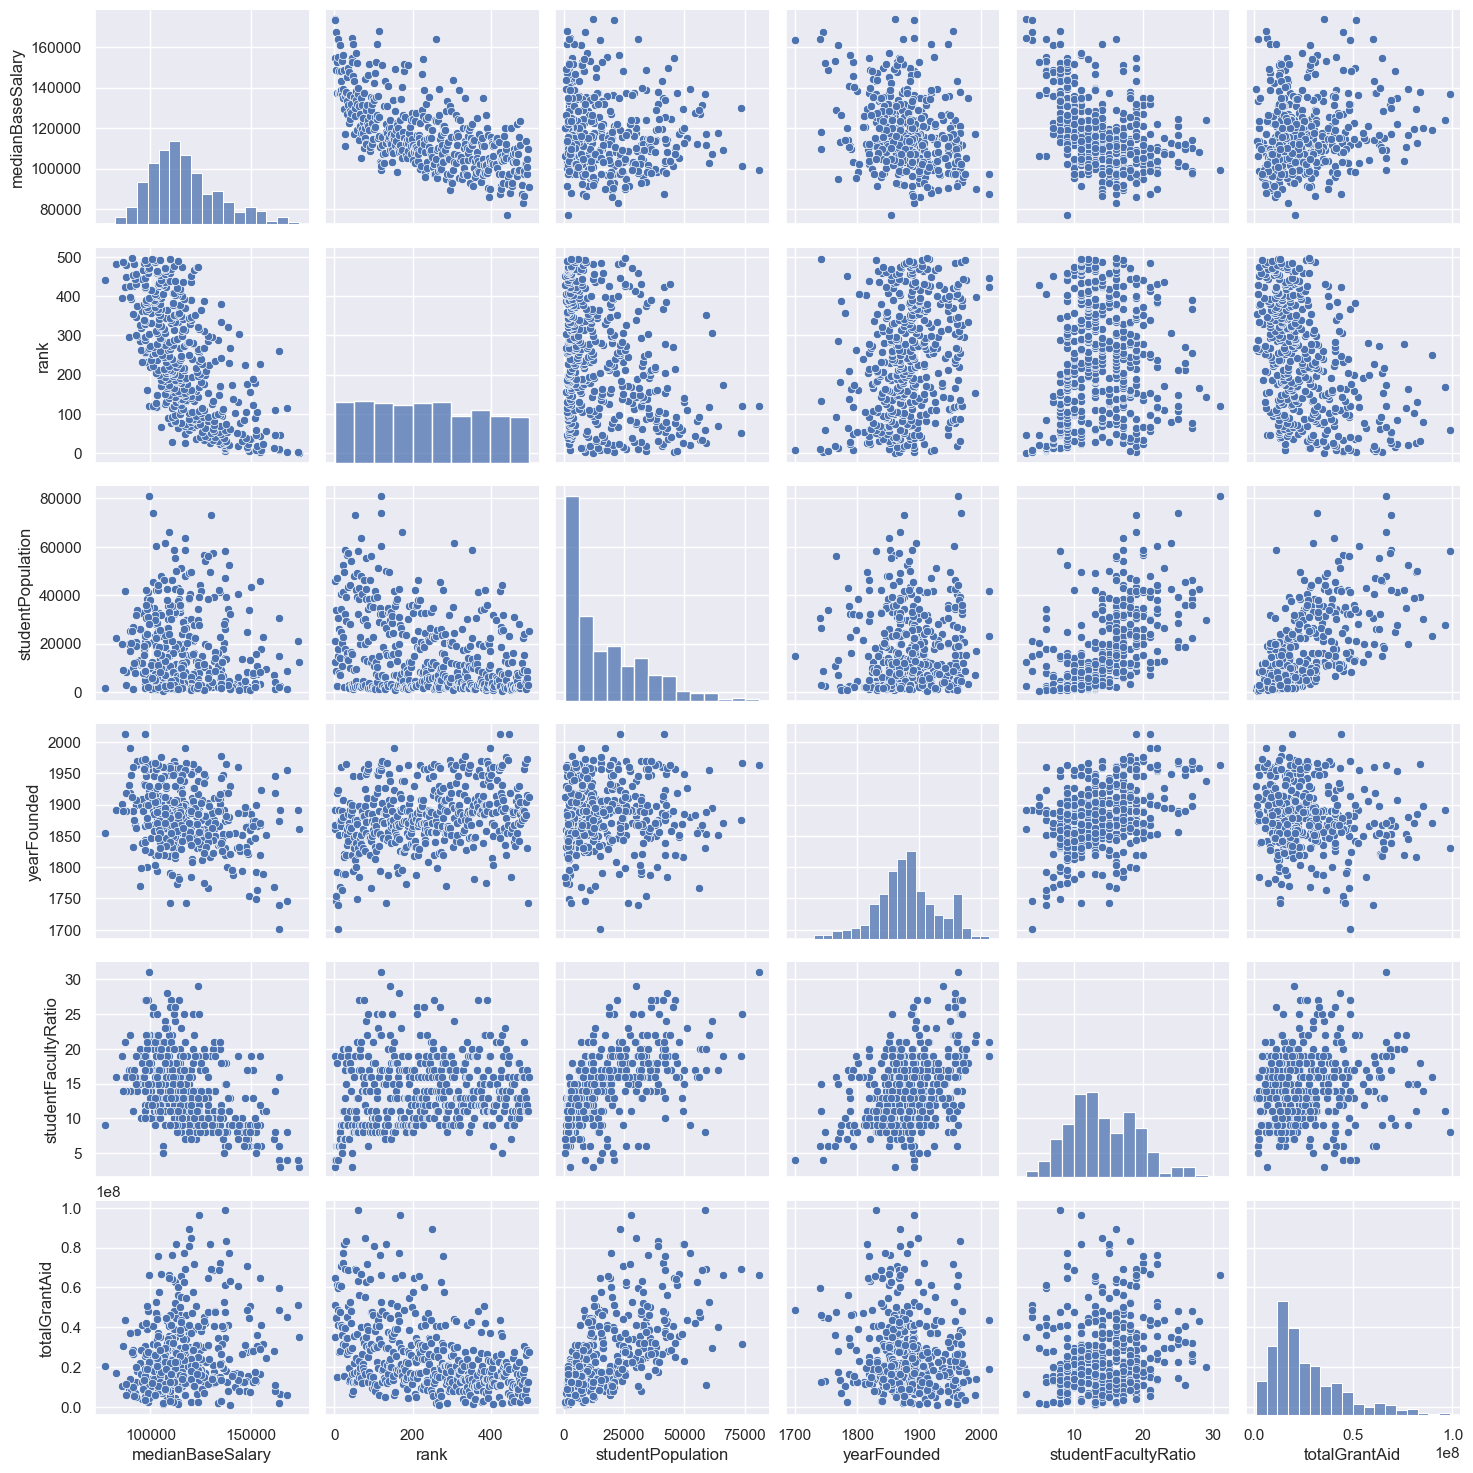

In [108]:
sns.pairplot(df_colleges)

Taking a look at the first row of plots (representing median base salary's relationships with the other numerical variables), we can see that a couple of the explanatory variables' relationships with the response variable are not linear (namely, with rank and student/faculty ratio). This indicates that we may get a better fit if we transform these variables so that their relationships with median base salary are linear. To transform these columns, I'll take the square root of them and use the transformed columns instead in a new model.

C:\Users\benja\AppData\Local\Temp\ipykernel_23284\32012047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_colleges["sqrt_rank"] = (df_colleges["rank"])**.5
C:\Users\benja\AppData\Local\Temp\ipykernel_23284\32012047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_colleges["sqrt_studentFacultyRatio"] = (df_colleges["studentFacultyRatio"])**.5


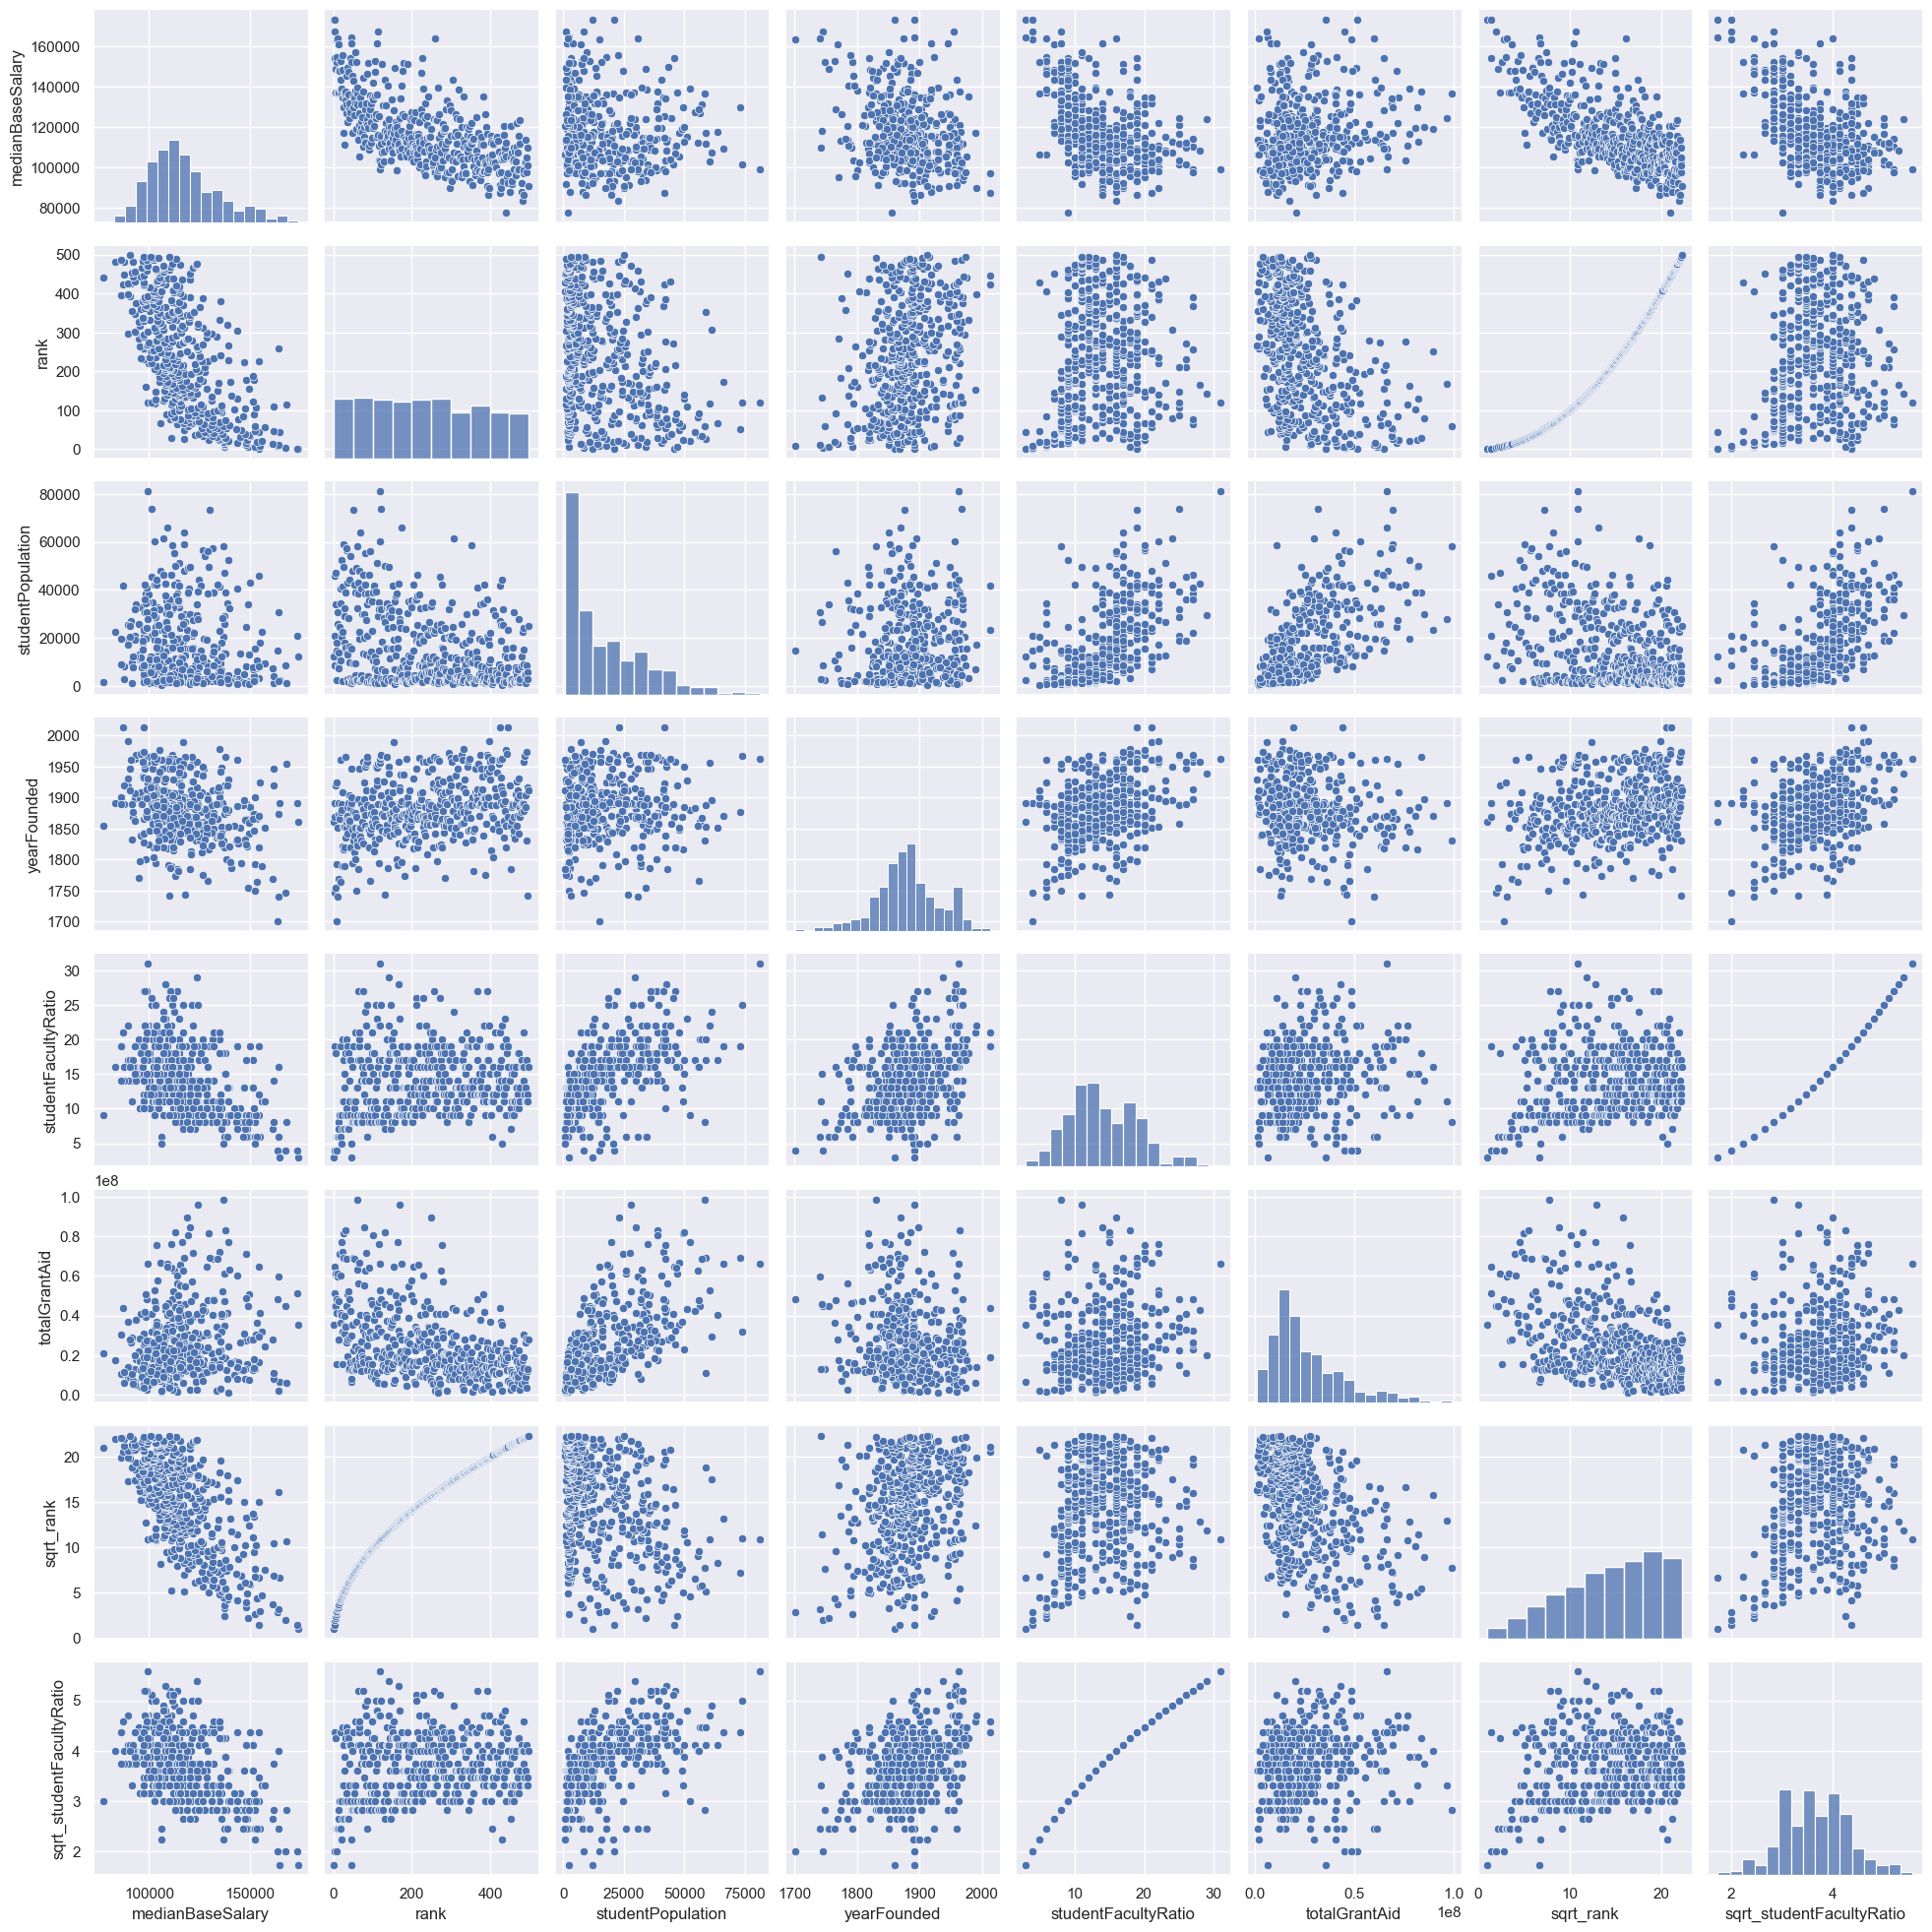

In [109]:
df_colleges["sqrt_rank"] = (df_colleges["rank"])**.5
df_colleges["sqrt_studentFacultyRatio"] = (df_colleges["studentFacultyRatio"])**.5
sns.pairplot(df_colleges)

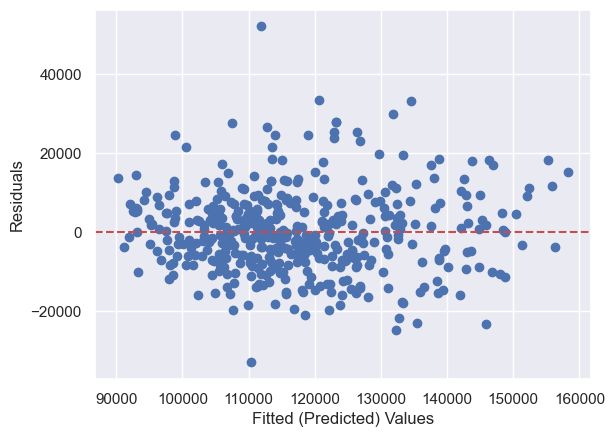

In [110]:
transformed_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+yearFounded+sqrt_studentFacultyRatio+totalGrantAid+campusSetting+collegeType", data=df_colleges).fit()
plt.scatter(transformed_model.fittedvalues, transformed_model.resid)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Fitted (Predicted) Values")
plt.ylabel("Residuals")
plt.show()

Now we can see, both in the new pairplot and the new residual plot, that this transformed model does a much better job of meeting the linearity assumption.

Now, checking for possible interaction terms between categorical and numerical variables:

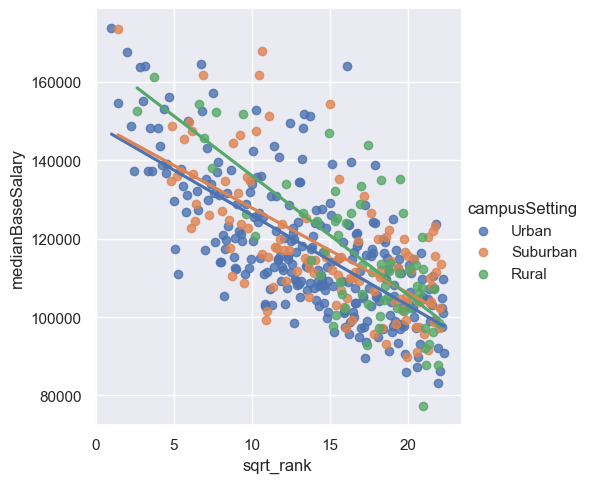

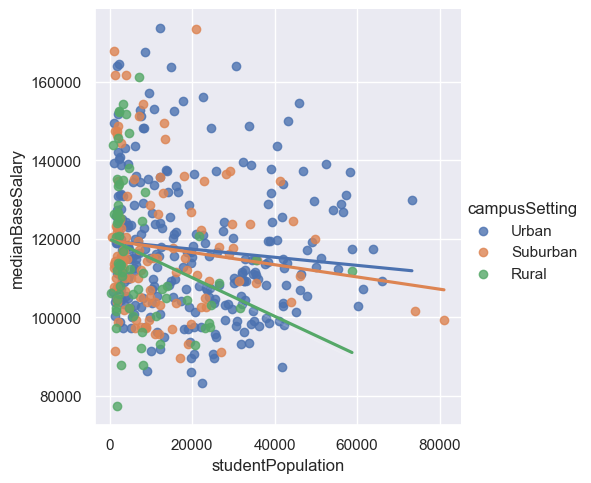

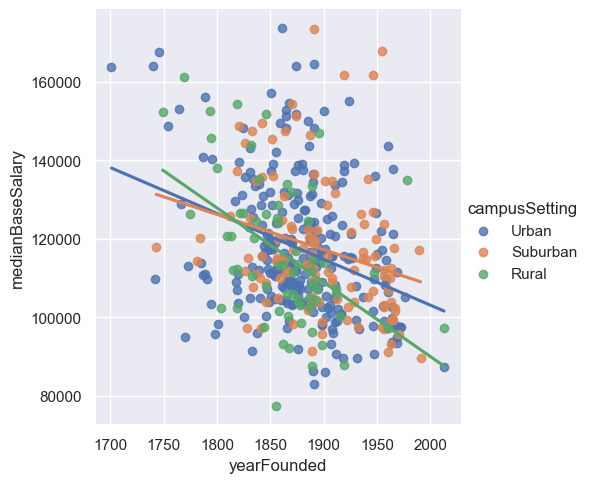

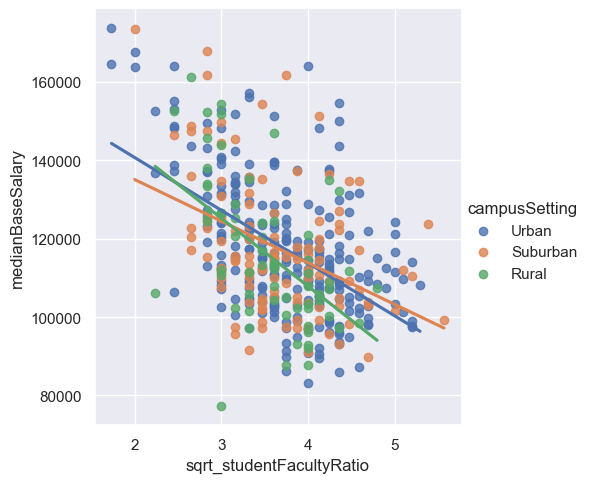

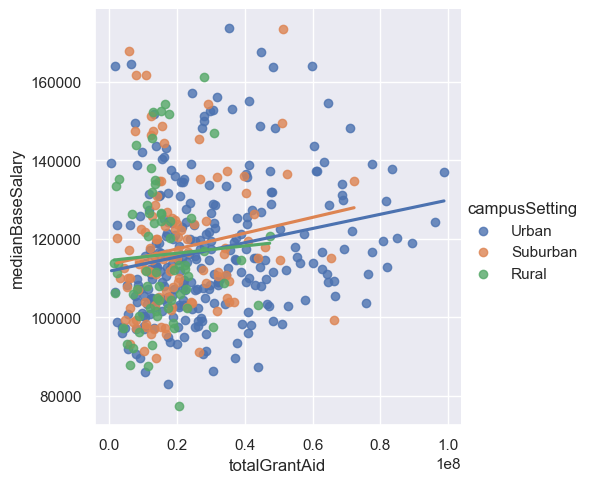

In [111]:
sns.lmplot(data=df_colleges, x="sqrt_rank", y="medianBaseSalary", hue="campusSetting", ci=False)
sns.lmplot(data=df_colleges, x="studentPopulation", y="medianBaseSalary", hue="campusSetting", ci=False)
sns.lmplot(data=df_colleges, x="yearFounded", y="medianBaseSalary", hue="campusSetting", ci=False)
sns.lmplot(data=df_colleges, x="sqrt_studentFacultyRatio", y="medianBaseSalary", hue="campusSetting", ci=False)
sns.lmplot(data=df_colleges, x="totalGrantAid", y="medianBaseSalary", hue="campusSetting", ci=False)

Based on the lmplots, the two numerical variables that exhibit the most interaction with campus setting are student population and year founded (biggest difference in slopes), so we will incorporate these two variables as interaction terms in one of our models.

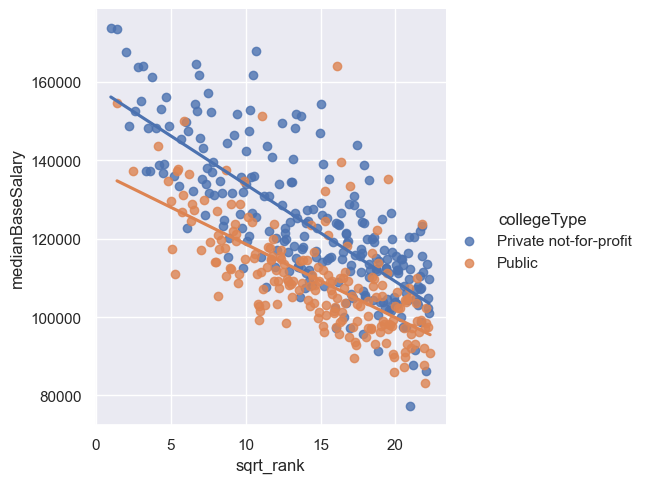

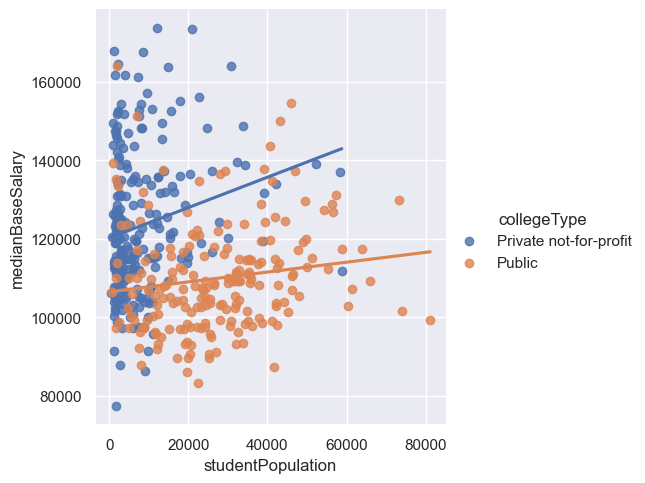

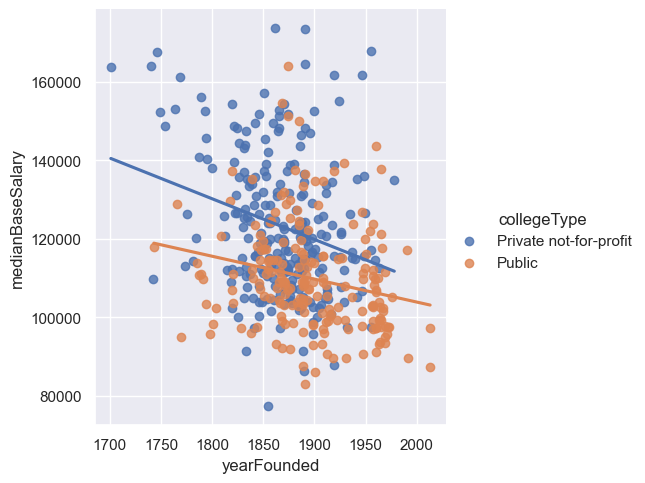

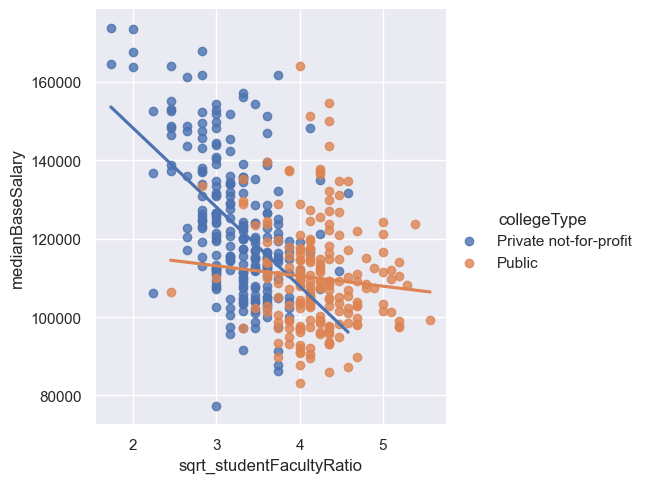

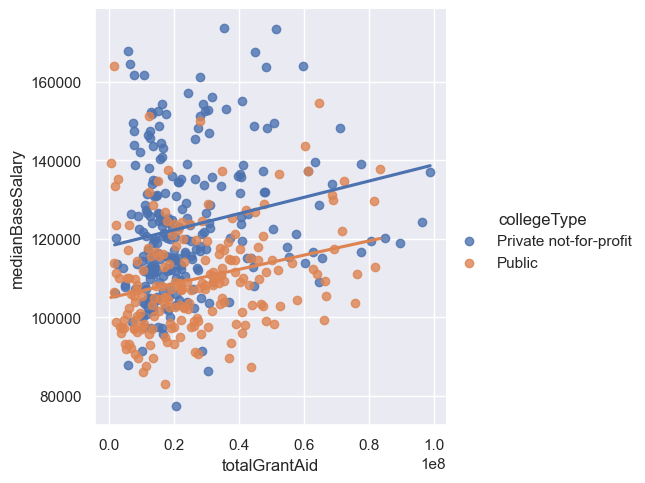

In [112]:
sns.lmplot(data=df_colleges, x="sqrt_rank", y="medianBaseSalary", hue="collegeType", ci=False)
sns.lmplot(data=df_colleges, x="studentPopulation", y="medianBaseSalary", hue="collegeType", ci=False)
sns.lmplot(data=df_colleges, x="yearFounded", y="medianBaseSalary", hue="collegeType", ci=False)
sns.lmplot(data=df_colleges, x="sqrt_studentFacultyRatio", y="medianBaseSalary", hue="collegeType", ci=False)
sns.lmplot(data=df_colleges, x="totalGrantAid", y="medianBaseSalary", hue="collegeType", ci=False)

For college type, the main explanatory variable that exhibits the strongest interaction is the square root of the student/faculty ratio, so this will be another interaction term for our model.

## 5. Predictive Models

Before performing the train/test split, I need to create indicator variables from the explanatory variables:

In [113]:
df_colleges = df_colleges.drop(columns=["rank", "studentFacultyRatio"])

With that out of the way, I can now create a 80/20 train/test split. Additionally, I need to scale the numerical explanatory variables so that the resulting slopes can be interpreted as to the nature of how important the variables are when predicting median base salary.

In [114]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_colleges, train_size=.8, random_state=1)

In [115]:
expl_vars = ["sqrt_rank", "studentPopulation", "yearFounded", "sqrt_studentFacultyRatio", "totalGrantAid", "campusSetting", "collegeType"]
features_train = df_train[expl_vars]
target_train = df_train["medianBaseSalary"]

features_test = df_test[expl_vars]
target_test = df_test["medianBaseSalary"]

In [116]:
from sklearn.preprocessing import StandardScaler
numeric_vars = ["sqrt_rank", "studentPopulation", "yearFounded", "sqrt_studentFacultyRatio", "totalGrantAid"]
scaler = StandardScaler()
scaled_numeric_train = scaler.fit_transform(df_train[numeric_vars])
features_train[numeric_vars] = scaled_numeric_train

C:\Users\benja\AppData\Local\Temp\ipykernel_23284\3382606873.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric_vars] = scaled_numeric_train


In [117]:
scaled_numeric_test = scaler.transform(df_test[numeric_vars])
features_test[numeric_vars] = scaled_numeric_test

C:\Users\benja\AppData\Local\Temp\ipykernel_23284\4115537562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[numeric_vars] = scaled_numeric_test


### Non-linearized full linear regression model

The first model I will create is the full model containing all of the explanatory variables:

In [121]:
full_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+yearFounded+sqrt_studentFacultyRatio+totalGrantAid+campusSetting+collegeType", data=df_train).fit()

In [124]:
from sklearn.metrics import r2_score
full_pred_test = full_model.predict(df_test)
r2_score(target_test, full_pred_test)

0.5151920730357169

The test R^2 for this full model is .51519.

Next, the full model with the interaction terms selected earlier:

In [125]:
interaction_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+yearFounded+sqrt_studentFacultyRatio+totalGrantAid+campusSetting+collegeType+studentPopulation*campusSetting+yearFounded*campusSetting+sqrt_studentFacultyRatio*collegeType", data=df_train).fit()

In [126]:
interaction_pred_test = interaction_model.predict(df_test)
r2_score(target_test, interaction_pred_test)

0.4889082376386702

The test R^2 for the interaction term model is .48891.

Finally, I will use the backwards selection algorithm to try and maximize test R^2.

In [127]:
current_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+yearFounded+sqrt_studentFacultyRatio+totalGrantAid+campusSetting+collegeType", data=df_train).fit()
current_pred_test = current_model.predict(df_test)
r2_score(target_test, current_pred_test)

0.5151920730357169

In [131]:
test_model = smf.ols(formula="medianBaseSalary~studentPopulation+yearFounded+sqrt_studentFacultyRatio+totalGrantAid+campusSetting+collegeType", data=df_train).fit()
test_pred_test = test_model.predict(df_test)
r2_score(target_test, test_pred_test)

0.23346439374958117

In [130]:
test_model = smf.ols(formula="medianBaseSalary~sqrt_rank+yearFounded+sqrt_studentFacultyRatio+totalGrantAid+campusSetting+collegeType", data=df_train).fit()
test_pred_test = test_model.predict(df_test)
r2_score(target_test, test_pred_test)

0.49508842273195264

In [132]:
test_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+sqrt_studentFacultyRatio+totalGrantAid+campusSetting+collegeType", data=df_train).fit()
test_pred_test = test_model.predict(df_test)
r2_score(target_test, test_pred_test)

0.517242200923023

In [133]:
test_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+yearFounded+totalGrantAid+campusSetting+collegeType", data=df_train).fit()
test_pred_test = test_model.predict(df_test)
r2_score(target_test, test_pred_test)

0.5091292847226414

In [134]:
test_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+yearFounded+sqrt_studentFacultyRatio+campusSetting+collegeType", data=df_train).fit()
test_pred_test = test_model.predict(df_test)
r2_score(target_test, test_pred_test)

0.5150548117362028

In [135]:
test_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+yearFounded+sqrt_studentFacultyRatio+totalGrantAid+collegeType", data=df_train).fit()
test_pred_test = test_model.predict(df_test)
r2_score(target_test, test_pred_test)

0.5154787441404924

In [136]:
test_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+yearFounded+sqrt_studentFacultyRatio+totalGrantAid+campusSetting", data=df_train).fit()
test_pred_test = test_model.predict(df_test)
r2_score(target_test, test_pred_test)

0.5092353561664849

In [138]:
current_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+sqrt_studentFacultyRatio+totalGrantAid+campusSetting+collegeType", data=df_train).fit()
current_pred_test = current_model.predict(df_test)
r2_score(target_test, current_pred_test)

0.517242200923023

In [140]:
test_model = smf.ols(formula="medianBaseSalary~studentPopulation+sqrt_studentFacultyRatio+totalGrantAid+campusSetting+collegeType", data=df_train).fit()
test_pred_test = test_model.predict(df_test)
r2_score(target_test, test_pred_test)

0.2465116996022041

In [141]:
test_model = smf.ols(formula="medianBaseSalary~sqrt_rank+sqrt_studentFacultyRatio+totalGrantAid+campusSetting+collegeType", data=df_train).fit()
test_pred_test = test_model.predict(df_test)
r2_score(target_test, test_pred_test)

0.4968318997873795

In [142]:
test_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+totalGrantAid+campusSetting+collegeType", data=df_train).fit()
test_pred_test = test_model.predict(df_test)
r2_score(target_test, test_pred_test)

0.5098543352254526

In [143]:
test_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+sqrt_studentFacultyRatio+campusSetting+collegeType", data=df_train).fit()
test_pred_test = test_model.predict(df_test)
r2_score(target_test, test_pred_test)

0.51720928381133

In [144]:
test_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+sqrt_studentFacultyRatio+totalGrantAid+collegeType", data=df_train).fit()
test_pred_test = test_model.predict(df_test)
r2_score(target_test, test_pred_test)

0.5165057081074488

In [145]:
test_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+sqrt_studentFacultyRatio+totalGrantAid+campusSetting", data=df_train).fit()
test_pred_test = test_model.predict(df_test)
r2_score(target_test, test_pred_test)

0.5101627689398602

In [146]:
backwards_selection_model = smf.ols(formula="medianBaseSalary~sqrt_rank+studentPopulation+sqrt_studentFacultyRatio+totalGrantAid+campusSetting+collegeType", data=df_train).fit()
backwards_pred_test = backwards_selection_model.predict(df_test)
r2_score(target_test, backwards_pred_test)

0.517242200923023

The final model from our backwards selection algorithm (which eliminated year founded) resulted in a test R^2 of .51724.

## 6. Best Model Discussion

Based on the test R^2 values we found, it can be concluded that the backwards selection model is the best of the three models, as it had the highest test R^2.

In [147]:
backwards_selection_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       medianBaseSalary   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     97.05
Date:                Fri, 04 Apr 2025   Prob (F-statistic):           5.61e-78
Time:                        22:00:32   Log-Likelihood:                -3805.0
No. Observations:                 357   AIC:                             7626.
Df Residuals:                     349   BIC:                             7657.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1.706e+05   4360.419     39.115      0.000    1.62e+05    1.79e+05
campusSetting[T.Suburban] -1755.2651   1818.027     -0.965      0.335   -5330.933    1820.403
campusSetting[T.Urban]    -1972.1215   1671.698     -1.180      0.239   -5259.992    1315.749
collegeType[T.Public]     -5493.7306   1853.829     -2.963      0.003   -9139.813   -1847.648
sqrt_rank                 -2549.8074    138.114    -18.462      0.000   -2821.449   -2278.166
studentPopulation            -0.2075      0.071     -2.927      0.004      -0.347      -0.068
sqrt_studentFacultyRatio  -2439.8387   1433.488     -1.702      0.090   -5259.201     379.524
totalGrantAid              5.518e-07    4.7e-05      0.012      0.991   -9.19e-05     9.3e-05
==============================================================================
Omnibus:                       10.316   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.392
Skew:                           0.325   Prob(JB):                      0.00336
Kurtosis:                       3.587   Cond. No.                     2.59e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.59e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Equation:

$\hat{medianBaseSalary}$ = 170600
                            - 1755.2651 * campusSetting(suburban)
                            - 1972.1215 * campusSetting(urban)
                            - 5493.7306 * collegeType(public)
                            - 2549.8074 * sqrt_rank
                            - 0.2075 * studentPopulation
                            - 2439.8387 * sqrt_studentFacultyRatio
                            + .0000005518 * totalGrantAid


Overall, a test R^2 of .51724 means that the model does a solid (but not great) job at predicting median base salary for colleges. Since this is the best model we found, we can conclude that the backwards selection algorithm indicates that the year a college was founded overfit the model and did not bring enough predictive power.

In [149]:
df_colleges.corr(numeric_only=True)

,medianBaseSalary,studentPopulation,yearFounded,totalGrantAid,sqrt_rank,sqrt_studentFacultyRatio
medianBaseSalary,1.000000,-0.114136,-0.321403,0.176904,-0.687833,-0.494833
studentPopulation,-0.114136,1.000000,0.097747,0.635686,-0.343400,0.591563
yearFounded,-0.321403,0.097747,1.000000,-0.150673,0.285424,0.427314
totalGrantAid,0.176904,0.635686,-0.150673,1.000000,-0.459508,0.165628
sqrt_rank,-0.687833,-0.343400,0.285424,-0.459508,1.000000,0.208728
sqrt_studentFacultyRatio,-0.494833,0.591563,0.427314,0.165628,0.208728,1.000000


Additionally, because there are no correlations above .7 we can see that this model does not suffer from multicollinearity, so we can trust the slopes to accurately reflect the relationships between explanatory variables and median base salary. Since we scaled the explanatory variables at the beginning, we can also trust the magnitude of these slopes to accurately reflect how much predictive power each variable brings to the model. Therefore, we can conclude that college type (specifically a school being a public school) and square root of ranking bring the most predictive power to our model.

## 7. Conclusion

I would recommend this model to be used by students and other people interested in exploring different colleges and their starting salaries. While it's far from a perfect model, it provides a decent enough baseline as to how much different college graduates will earn after college. This model likely isn't the best one possible with this dataset; I did not explore any regularized models and instead opted to choose backwards selection. Additionally, I could have tried fitting a model with the untransformed rank and student/faculty ratio. Based on this analysis, it would be interesting to see how the model would change when faced with newer or older college data.